<div style="
    background:#1f77b4;
    color:white;
    padding:10px;
    border-radius:12px;
    font-size:18px;
    font-weight:bold;
    margin:20px 0;
    text-align:center;
">
I/ PREPARE FILE AND CONNECT TO BIG QUERY
</div>


In [1]:
!pip install --quiet google-cloud-bigquery pandas-gbq

from google.cloud import bigquery
from google.colab import auth
import pandas as pd
from google.colab import files
from IPython.display import Image, display

auth.authenticate_user()
print("Verifiy successful")

# Create client client
client = bigquery.Client(project='dungportfolio')

Verifiy successful


In [2]:
# @title
upload = files.upload()

Saving confusion_matrix.png to confusion_matrix.png
Saving logistic.png to logistic.png
Saving tree_v1.png to tree_v1.png
Saving tree_v2.png to tree_v2.png


<div style="
    background:#1f77b4;
    color:white;
    padding:10px;
    border-radius:12px;
    font-size:18px;
    font-weight:bold;
    margin:20px 0;
    text-align:center;
">
II/ BOOSTED TREE MODEL
</div>


<div style="
    background:#f2f2f2;
    padding:10px;
    border-radius:8px;
    font-size:18px;
    font-weight:bold;
    margin-top:10px;
">
1. Creating model
</div>


In [4]:
# @title
query_boosted_tree = """
CREATE OR REPLACE MODEL `dungportfolio.RawData.churn_boosted_tree`
OPTIONS (
  model_type = 'boosted_tree_classifier',
  input_label_cols = ['Churned'],
  max_iterations = 50,
  max_tree_depth = 5,
  subsample = 0.8,
  enable_global_explain = TRUE
) AS
SELECT
    * EXCEPT(customer_id, data_split)
FROM `dungportfolio.RawData.customer_churn_split`
WHERE data_split = 'TRAIN';
"""

client.query(query_boosted_tree).result()
print("Finish training model: churn_boosted_tree")

Finish training model: churn_boosted_tree


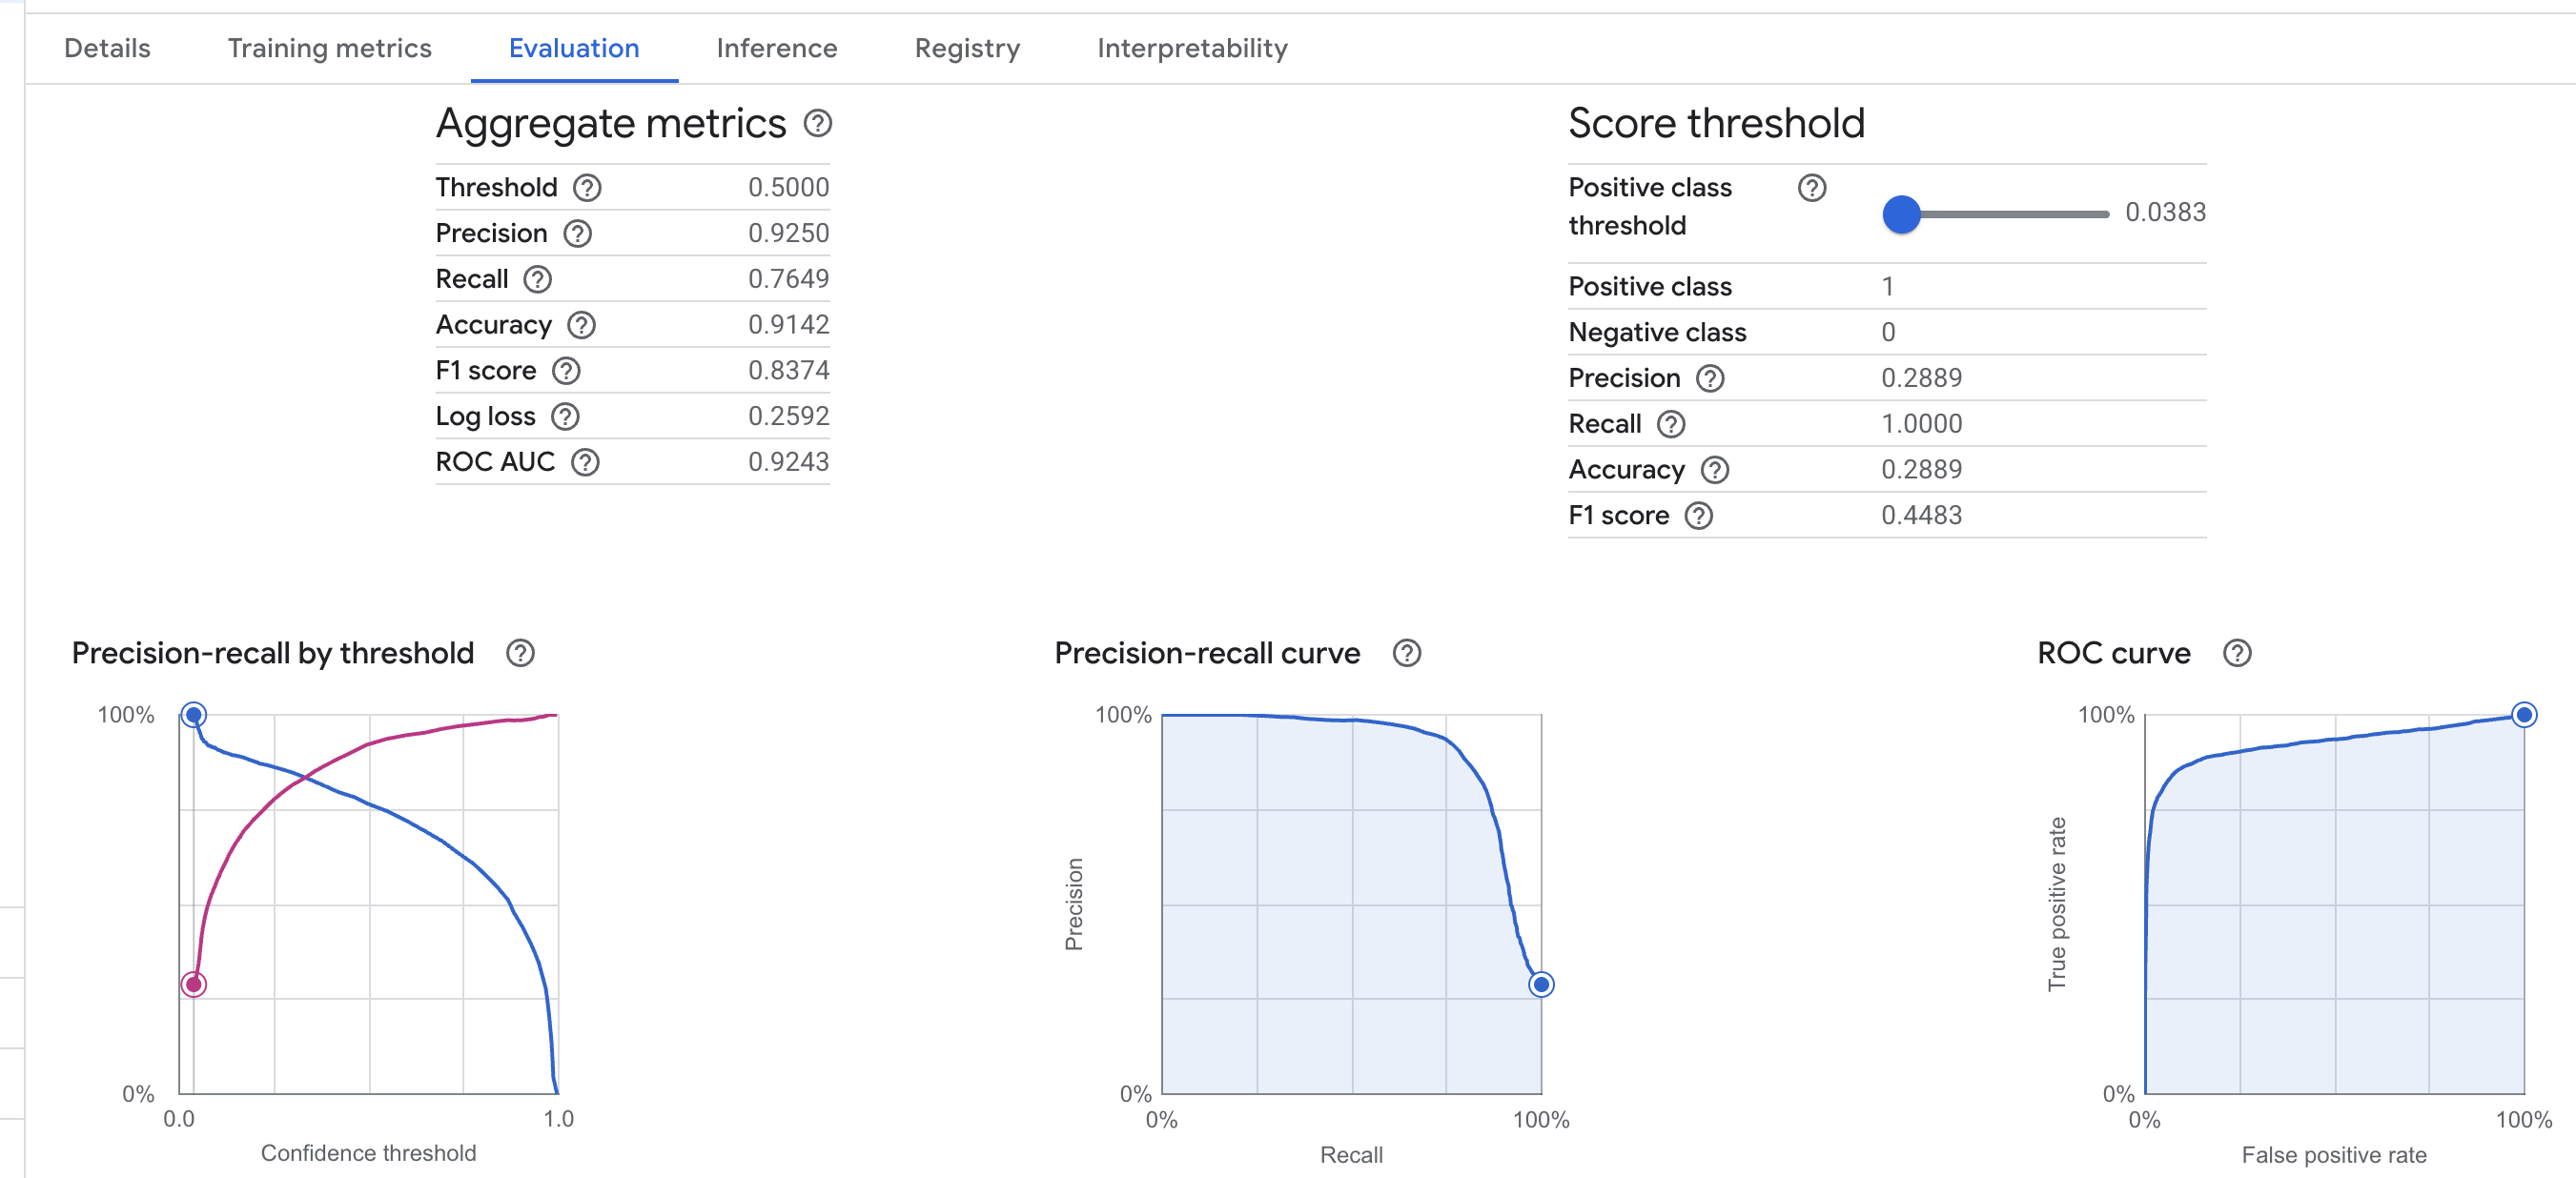

In [12]:
# @title
display(Image(filename="tree_v1.png"))

<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
<strong>The model is feasible and stable:</strong> ROC AUC of ~0.92 shows very good churn/non-churn differentiation right from the first build, with clear signal data and no serious interference.<br>
<strong>Operationally acceptable results:</strong> At default threshold 0.5, high precision (~93%) with reasonable recall (~76%) is suitable for initial churn intervention tests.
</div>

<div style="
    background:#f2f2f2;
    padding:10px;
    border-radius:8px;
    font-size:18px;
    font-weight:bold;
    margin-top:10px;
">
2. Evaluate on test set
</div>


In [6]:
# @title
eval_query = """
SELECT *
FROM ML.EVALUATE(
    MODEL `dungportfolio.RawData.churn_boosted_tree`,
    (
        SELECT *
        FROM `dungportfolio.RawData.customer_churn_split`
        WHERE data_split = 'TEST'
    )
)
"""

df_eval = client.query(eval_query).to_dataframe()
print("\nEvaluate Boosted Tree on test set:")
display(df_eval)


Evaluate Boosted Tree on test set:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.915,0.758549,0.909817,0.829462,0.269258,0.917692


<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
The test results were similar to those during training, indicating that the model performed relatively stably and did not overfit.
</div>

<div style="
    background:#f2f2f2;
    padding:10px;
    border-radius:8px;
    font-size:18px;
    font-weight:bold;
    margin-top:10px;
">
3. Explain model
</div>


In [4]:
# @title
explain_query = """
SELECT *
FROM ML.GLOBAL_EXPLAIN(
    MODEL `dungportfolio.RawData.churn_boosted_tree`,
    STRUCT(30 AS top_k_features)
)
"""

df_explain = client.query(explain_query).to_dataframe()
print("\nGlobal Explain (top features):")
display(df_explain)


Global Explain (top features):


,feature,attribution
0,Customer_Service_Calls,0.360017
1,Lifetime_Value,0.355938
2,Cart_Abandonment_Rate,0.250278
3,Age,0.155936
4,Days_Since_Last_Purchase,0.151666
5,Email_Open_Rate,0.129607
6,Discount_Usage_Rate,0.125301
7,Total_Purchases,0.073696
8,Returns_Rate,0.070058
9,Session_Duration_Avg,0.052773


<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
The ML_Explain results show the contribution level of each feature to the model. The model is optimized by removing features with a attribution level < 0.01
</div>

<div style="
    background:#f2f2f2;
    padding:10px;
    border-radius:8px;
    font-size:18px;
    font-weight:bold;
    margin-top:10px;
">
4. Rebuild model after explain
</div>


<div style="
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
Excluding variables: Based on the results of ML_Explain, variables with little influence on the model can be excluded, specifically variables with attribution < 0.01 and variables not included in the list because their attribution is too small.
</div>

In [5]:
# @title
query_v2 = """
CREATE OR REPLACE MODEL `dungportfolio.RawData.churn_boosted_tree_v2`
OPTIONS (
  model_type = 'boosted_tree_classifier',
  input_label_cols = ['Churned'],
  max_iterations = 50,
  max_tree_depth = 5,
  subsample = 0.8,
  enable_global_explain = TRUE
) AS
SELECT
    * EXCEPT(
        customer_id
        ,data_split
        ,credit_balance
        ,signup_quarter
        ,city
        ,country
        ,gender
        ,membership_years
        ,payment_method_diversity
    )
FROM `dungportfolio.RawData.customer_churn_split`
WHERE data_split = 'TRAIN';
"""

client.query(query_v2).result()
print("Finish training model: churn_boosted_tree_v2")

# Evaluate on test set
eval_v2_query = """
SELECT *
FROM ML.EVALUATE(
    MODEL `dungportfolio.RawData.churn_boosted_tree_v2`,
    (
        SELECT *
        FROM `dungportfolio.RawData.customer_churn_split`
        WHERE data_split = 'TEST'
    )
)
"""

df_eval_v2 = client.query(eval_v2_query).to_dataframe()
print("\n Evaluate Boosted Tree v2 on test set:")
display(df_eval_v2)

Finish training model: churn_boosted_tree_v2

 Evaluate Boosted Tree v2 on test set:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.914644,0.755095,0.908819,0.827247,0.27096,0.917246


<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
The evaluation results on the test set for model v2 are <strong>relatively similar</strong> (it could be said that v2 is slightly better), but the model is <strong>significantly lighter</strong> after removing 7 features. Therefore, using model v2 is reasonable.<br>
<strong>==> Now it's time to optimize the model results according to business needs.</strong>
</div>

<div style="
    background:#f2f2f2;
    padding:10px;
    border-radius:8px;
    font-size:18px;
    font-weight:bold;
    margin-top:10px;
">
6. Choosing threshold for business needs
</div>


<div style="
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
Below are the results of running model v2 and the metrics based on threshold = 0.21.
</div>

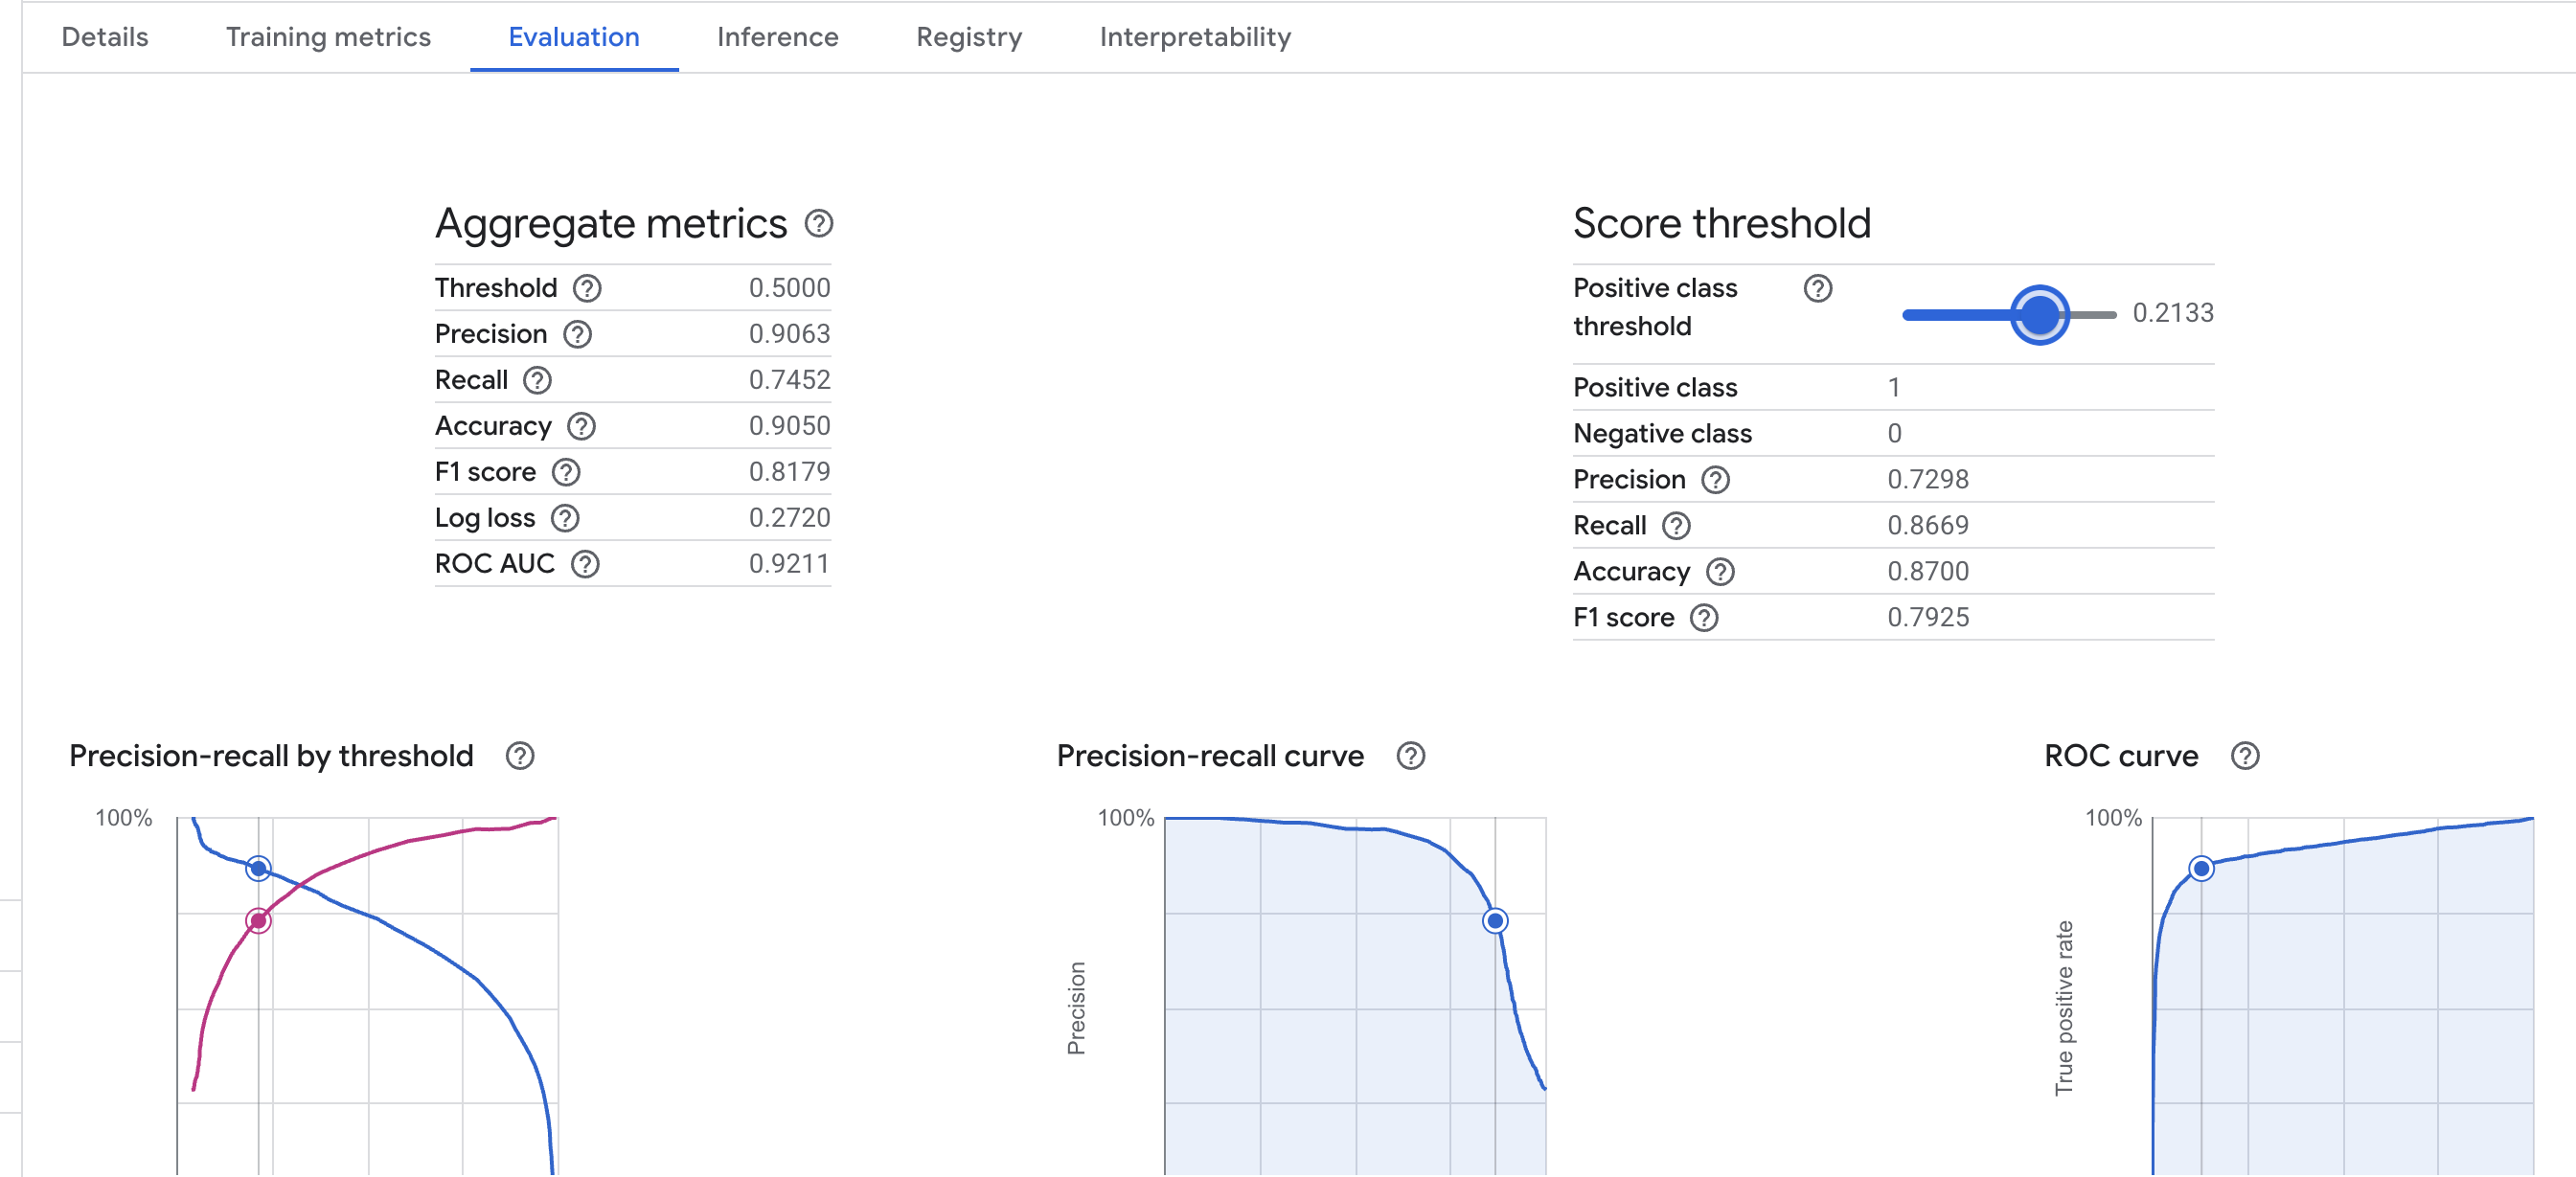

In [20]:
# @title
display(Image(filename="tree_v2.png"))

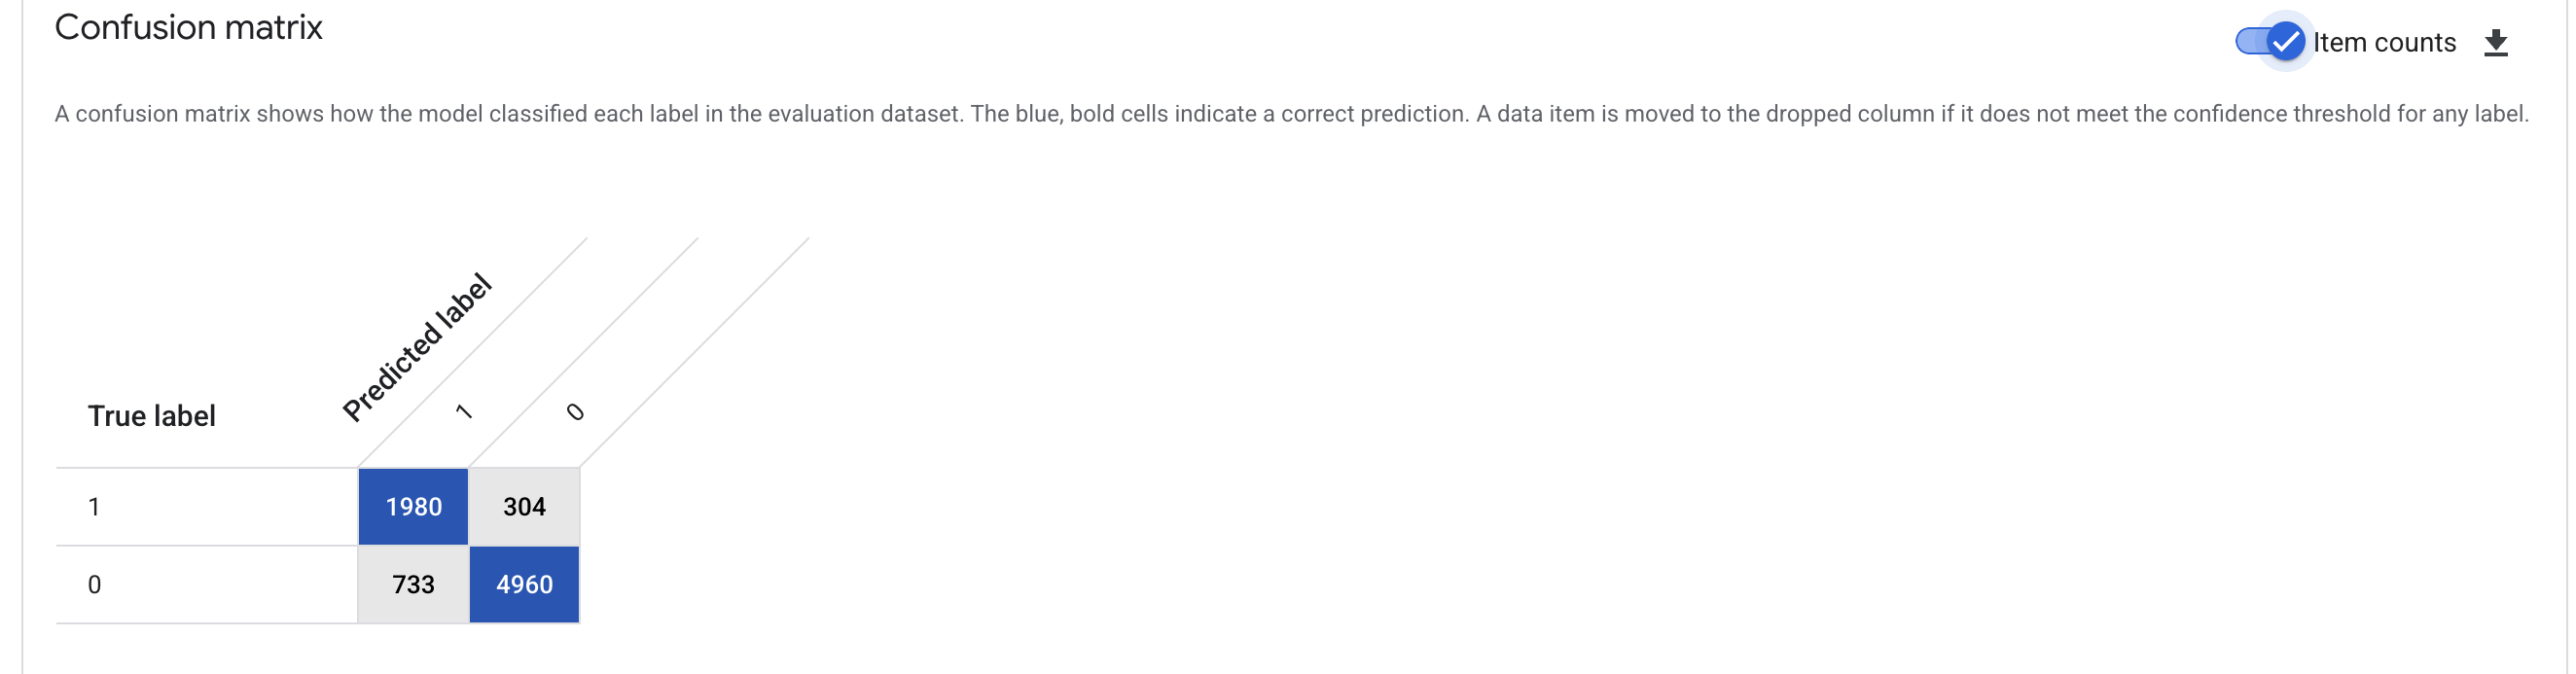

In [19]:
# @title
display(Image(filename="confusion_matrix.png"))

<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
<strong>Business needs</strong><br>
Identify potential customers who may leave to <strong><em>intervene early and optimize for each customer</strong></em> whenever possible.<br><br>
<strong>Transforming business needs</strong><br>
<strong>Early intervention:</strong> This means the model will prioritize predicting the number of customers most likely to churn <strong><em>(prioritizing recall)</strong></em>, so choosing a threshold of 0.21 is appropriate: the optimal rate of churning customers that can be <strong>intervened early is approximately 87%</strong> (missing rate ~13%), but the rate of customers who are bothered will be at an acceptable low level.<br>
<strong>Personalization:</strong> To personalize, it's necessary to understand the reasons behind each customer's departure, so <em>a logistic model is very suitable</em> for explaining this.
</div>

<div style="
    background:#1f77b4;
    color:white;
    padding:10px;
    border-radius:12px;
    font-size:18px;
    font-weight:bold;
    margin:20px 0;
    text-align:center;
">
III/ LOGISTIC REGRESSION MODEL
</div>


<div style="
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
If the Boosted Tree model answers the question: <em><strong>"Who is likely to churn?"</em></strong>, then the Logistic model helps answer the question: <em><strong>"Why do they churn?"</em></strong>, which helps personalize strategies and segment behavior into larger groups.
</div>

In [6]:
# @title
query_logistic = """
CREATE OR REPLACE MODEL `dungportfolio.RawData.churn_logistic_model`
OPTIONS (
  model_type = 'logistic_reg',
  input_label_cols = ['churned'],
  auto_class_weights = TRUE,
  standardize_features = FALSE
) AS
SELECT
   * EXCEPT(customer_id, data_split)
FROM `dungportfolio.RawData.customer_churn_split_logistic`
WHERE data_split = 'TRAIN';
"""

client.query(query_logistic).result()
print("Finish training churn_logistic_model")

# Weights & odds ratio
weights_query = """
SELECT
  processed_input,
  weight,
  EXP(weight) AS odds_ratio
FROM ML.WEIGHTS(MODEL `dungportfolio.RawData.churn_logistic_model`)
ORDER BY ABS(weight) DESC
"""

df_weights = client.query(weights_query).to_dataframe()
print("\nLogistic Weights & Odds Ratio:")
display(df_weights)

Finish training churn_logistic_model

Logistic Weights & Odds Ratio:


,processed_input,weight,odds_ratio
0,Customer_Service_Calls,0.553895,1.740017
1,Cart_Abandonment_Rate,0.366786,1.443088
2,Email_Open_Rate,-0.166257,0.846828
3,__INTERCEPT__,-0.132577,0.875836
4,Pages_Per_Session,-0.122759,0.884476
5,Total_Purchases,0.105186,1.110917
6,Mobile_App_Usage,-0.038874,0.961872
7,Social_Media_Engagement_Score,-0.036367,0.964287
8,Login_Frequency,-0.021711,0.978523
9,Session_Duration_Avg,-0.020979,0.979240


<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
- <em>Customer_Service_Calls</em> and <em>Cart_Abandonment_Rate</em> are the two factors that most strongly increase churn (OR > 1), indicating that customers who frequently make customer service calls or abandon their shopping carts have a <strong>significantly higher churn risk</strong> compared to other variables.<br>
- <em>The remaining variables</em> have OR < 1, so they tend to reduce churn, but their influence is weak and stable, mainly playing a <strong>supporting role</strong> rather than being the main driver.
</div>

<div style="
    background:#1f77b4;
    color:white;
    padding:10px;
    border-radius:12px;
    font-size:18px;
    font-weight:bold;
    margin:20px 0;
    text-align:center;
">
IV/ CONSLUTION
</div>


<div style="
    background:#f2f2f2;
    padding:10px;
    border-radius:8px;
    font-size:18px;
    font-weight:bold;
    margin-top:10px;
">
1. Actionable recommendation
</div>


<div style="
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
After explaining the causes of churn, using customer_service_calls and cart_abandonment_rate as key roles for behavioral segmentation is clearly justified.
</div>

In [17]:
# @title
root_cause_query = """
CREATE OR REPLACE TABLE `dungportfolio.RawData.customer_churn_rootcause` AS
WITH churn_tree AS (
SELECT
    customer_id
    ,ROUND(probs.prob,2) AS churn_probability
FROM ML.PREDICT(
        MODEL `dungportfolio.RawData.churn_boosted_tree_v2`,
        (SELECT * FROM `dungportfolio.RawData.ecommerce_cust_data`)
     ) t,
     UNNEST(t.predicted_Churned_probs) AS probs
WHERE probs.label = 1
  AND probs.prob >= 0.21
),

logistic_explain AS (
SELECT
    e.customer_id
    ,f.feature
    ,f.attribution
FROM ML.EXPLAIN_PREDICT(
    MODEL `dungportfolio.RawData.churn_logistic_model`,
    (
      SELECT
        * EXCEPT(data_split)
      FROM `dungportfolio.RawData.customer_churn_split_logistic`
    )
) e
CROSS JOIN UNNEST(e.top_feature_attributions) AS f
),

ranked_drivers AS (
SELECT
    customer_id
    ,feature
    ,attribution
    ,ROW_NUMBER() OVER (
        PARTITION BY customer_id
        ORDER BY attribution DESC
     ) AS rn
FROM logistic_explain
WHERE attribution > 0
),

behavior_segment AS (
SELECT
    t.customer_id
    ,churn_probability
    ,STRING_AGG(d.feature, ' + ') AS top_3_churn_drivers
    ,
FROM churn_tree t
LEFT JOIN ranked_drivers d
    ON t.customer_id = d.customer_id
   AND d.rn <= 3
GROUP BY
    t.customer_id
    ,t.churn_probability
ORDER BY churn_probability DESC
)

SELECT
    *
    ,CASE
        WHEN top_3_churn_drivers IS NULL
            THEN 'silent_risk customer'

        WHEN top_3_churn_drivers LIKE 'Customer_Service_Calls%'
            THEN 'high_complain customer'

        WHEN top_3_churn_drivers LIKE '%Cart_Abandonment_Rate + Customer_Service_Calls%'
            THEN 'high_cart_abandonment_rate & medium_complain customer'

        WHEN top_3_churn_drivers LIKE 'Total_Purchases + Customer_Service_Calls%'
            THEN 'low_purchases & medium_complain customer'

        WHEN top_3_churn_drivers LIKE '%+ Customer_Service_Calls +%'
            THEN 'low_engagement & medium_complain customer'

        ELSE 'low_engagement customer'
    END AS churn_cause

FROM behavior_segment;
"""

client.query(root_cause_query).result()

show_table_query = """
SELECT *
FROM `dungportfolio.RawData.customer_churn_rootcause`
ORDER BY churn_probability DESC
LIMIT 10
"""

group_segment_query = """
SELECT
    r.churn_cause
    ,COUNT(DISTINCT r.customer_id) AS customer_count
    ,ROUND(
        COUNT(DISTINCT r.customer_id)
        / SUM(COUNT(DISTINCT r.customer_id)) OVER() * 100
    ,2) AS pct_customers

    ,ROUND(SUM(d.average_order_value * d.total_purchases),2) AS total_revenue

    ,ROUND(
        SUM(d.average_order_value * d.total_purchases)
        / SUM(SUM(d.average_order_value * d.total_purchases)) OVER() * 100
    ,2) AS pct_revenue

FROM `dungportfolio.RawData.customer_churn_rootcause` r
JOIN `dungportfolio.RawData.ecommerce_cust_data` d
  ON r.customer_id = d.customer_id

GROUP BY r.churn_cause
ORDER BY total_revenue DESC;
"""

df_root = client.query(show_table_query).to_dataframe()
df_seg = client.query(group_segment_query).to_dataframe()
print("\n Root Cause Analysis:")
display(df_root)
print("\n")
print("\n Grouping segment")
display(df_seg)


 Root Cause Analysis:


,customer_id,churn_probability,top_3_churn_drivers,churn_cause
0,acee0fe9-bc6f-4204-952b-cceaee4c8cf7,1.00,Customer_Service_Calls + Total_Purchases,high_complain customer
1,610a540a-0a49-489b-a6fa-c846dfeddc4a,0.99,Total_Purchases + Customer_Service_Calls + Mob...,low_purchases & medium_complain customer
2,2611c836-5ac5-4a6e-9072-071562f97a42,0.99,Customer_Service_Calls + Total_Purchases,high_complain customer
3,8152035c-d068-4863-bd37-837467774ece,0.99,Cart_Abandonment_Rate + Customer_Service_Calls...,high_cart_abandonment_rate & medium_complain c...
4,9c20d9a7-f7b8-4286-b7be-7f33e9846939,0.99,Customer_Service_Calls + Cart_Abandonment_Rate...,high_complain customer
5,eeaf3296-9a12-47aa-b8ea-5052cdf67c69,0.99,Customer_Service_Calls + Total_Purchases + Ema...,high_complain customer
6,1f962e75-16b4-4669-a40b-5f3db91ecf8e,0.99,Total_Purchases,low_engagement customer
7,44819f84-b764-4015-b604-3cad99f70d2c,0.99,Cart_Abandonment_Rate + Customer_Service_Calls...,high_cart_abandonment_rate & medium_complain c...
8,bf9daf37-1970-40a1-827f-31d245a349c7,0.99,Customer_Service_Calls + Mobile_App_Usage,high_complain customer
9,1baa58e6-46b7-49af-bae7-0938bad9eaf0,0.99,Customer_Service_Calls + Total_Purchases + Pag...,high_complain customer





 Grouping segment


,churn_cause,customer_count,pct_customers,total_revenue,pct_revenue
0,high_complain customer,8115,47.50,12471185.32,51.49
1,low_engagement customer,5792,33.91,7078672.12,29.22
2,high_cart_abandonment_rate & medium_complain c...,2435,14.25,2497357.64,10.31
3,low_purchases & medium_complain customer,486,2.84,1724303.97,7.12
4,low_engagement & medium_complain customer,140,0.82,265135.48,1.09
5,silent_risk customer,115,0.67,184687.39,0.76


<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
The root_cause_analysis table is a summary of all customers predicted to churn (based on a threshold of 0.21), with the <strong>top 3 reasons from highest to lowest</strong>, specifically tailored to each customer, leading to the likelihood of churn. The churn_cause variable is based on using service call and cart abandonment features as the main keys and other features as support to segment campaigns based on behavioral groups rather than individualization.
</div>

<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
<strong>URGENT ACTION RECOMMENDATION:</strong><br>
- <strong>High-complaining customers:</strong> This group of customers is angry – a major cause of churn. However, their advantage is that although <strong><em>angry but still interactive</strong></em> (easy to intervene with), and they also account <strong> > 50% of revenue</strong>, so immediate de-escalation is necessary: ​​respond quickly within 24 hours, have one person handle the issue, resolve it thoroughly, offer promotions, confirm after resolution, etc.<br>
- <strong>Low-engagement customers:</strong> account for approximately <strong>30% of revenue</strong>. This group of customers is <strong><em>pleasant but passive</strong></em> and needs further engagement through methods such as personalized content suggestions, one-click actions, push notifications/emails based on recent behavior, etc.
</div>

<div style="
    background:#f2f2f2;
    padding:10px;
    border-radius:8px;
    font-size:18px;
    font-weight:bold;
    margin-top:10px;
">
2. Churn thresholds reference table
</div>


In [10]:
# @title
breakout_reference = """
SELECT
    'Customer_Service_Calls' AS feature_name,
    '≤ 5 calls' AS safe_zone,
    '> 5 calls' AS risk_zone,
    'Customers calling support more than 5 times show sharp churn increase' AS business_meaning

UNION ALL
SELECT
    'Login_Frequency',
    '≥ 6 logins',
    '< 6 logins',
    'Low login frequency signals disengagement'

UNION ALL
SELECT
    'Cart_Abandonment_Rate',
    '≤ 68%',
    '> 68%',
    'High cart abandonment indicates purchase friction'

UNION ALL
SELECT
    'Session_Duration_Avg',
    '≥ 20 minutes',
    '< 20 minutes',
    'Short sessions reflect weak product engagement'

UNION ALL
SELECT
    'Pages_Per_Session',
    '≥ 6 pages',
    '< 6 pages',
    'Low page views suggest shallow browsing behavior';
"""
df_breakout_reference = client.query(breakout_reference).to_dataframe()
print("\n Breakout_reference:")
display(df_breakout_reference)


 Breakout_reference:


,feature_name,safe_zone,risk_zone,business_meaning
0,Customer_Service_Calls,≤ 5 calls,> 5 calls,Customers calling support more than 5 times sh...
1,Login_Frequency,≥ 6 logins,< 6 logins,Low login frequency signals disengagement
2,Cart_Abandonment_Rate,≤ 68%,> 68%,High cart abandonment indicates purchase friction
3,Session_Duration_Avg,≥ 20 minutes,< 20 minutes,Short sessions reflect weak product engagement
4,Pages_Per_Session,≥ 6 pages,< 6 pages,Low page views suggest shallow browsing behavior


<div style="
    background:#f3f9fe;
    border-left:6px solid #1f77b4;
    padding:12px;
    border-radius:6px;
    font-size:15px;
    font-weight:400;
    margin:10px;
">
<strong>Behavioral Threshold Monitoring</strong><br>
Based on correlation analysis between component variables and target variables, scatter plots clearly show behavioral thresholds that, when exceeded, significantly increase churn rates. By monitoring customer behavior and intervening early when approaching these thresholds, churn rates can be reduced.<br><br>
<em><u>Note: These thresholds only serve as warnings that churn rates will increase if exceeded; they do not indicate whether customers will churn or not.</em></u>
</div>